In [1]:
import torch
import torch.nn as nn

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# U-NET

Paper: https://arxiv.org/pdf/1505.04597v1.pdf

Arquitectura de la red:

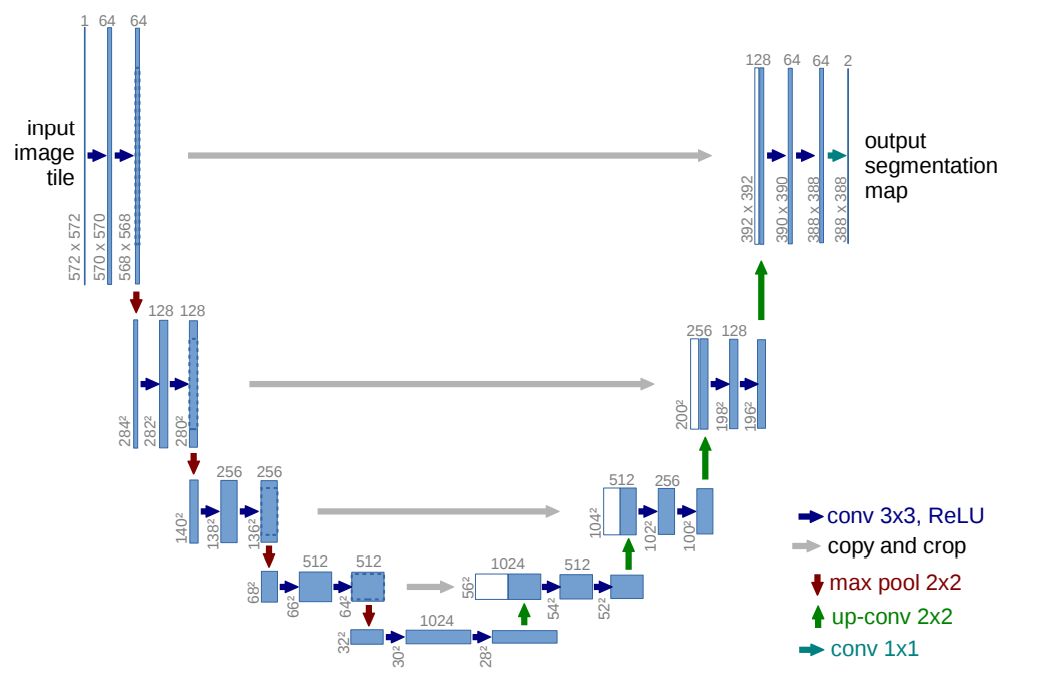

Recordemos que el objetivo con el cual se creó esta red, era poder segmentar imágenes médicas provenientes de un microscopio óptico que son monocromáticas, es decir que tienen un sólo canal de profundidad a diferencia de las imágenes "comunes" que tienen 3 o 4 canales (R, G, B, alpha).

In [3]:
class UNet(nn.Module):
    def __init__(self,
                 in_channels = 1,
                 depths: list = [64, 128, 256, 512, 1024],
                 n_classes: int = 2,
                 use_borders=False
                ):
        """
        Clase que implementa la arquitectura U-Net para segmentación semántica de imágenes

        Params:
        - in_channels: cantidad de canales de la imagen de entrada
        - depths: lista con la profundidad de los canales en cada etapa de down-sampling
        - n_classes: cantidad de clases posibles del target
        """
        super().__init__()
        self.depths = depths
        self.n_classes = n_classes + 2 if use_borders else n_classes + 1 # background o background+border
        self.in_channels = in_channels # Canales de la imagen: 1 en el paper
        self.down_path = self._make_down_path() # Creamos la izquierda de la U
        self.up_samplers, self.up_conv = self._make_up_path() # Creamos la derecha de la U
        self.output_layer = nn.Conv2d(  # Creamos la capa de salida encargada de clasificar cada pixel
            in_channels=self.depths[0],
            out_channels=self.n_classes,
            kernel_size=1,
            stride=1,
            padding=0
        )
        self.pool = nn.MaxPool2d(2, 2)

    @staticmethod
    def _make_conv_block(in_channels, out_channels):
        """
        Creamos un bloque convolucional de acuerdo al paper (o casi)
        - kernel_size = 3x3
        - stride = 1
        - padding = 1 -> en el paper usan padding=0

        Las dimensiones del feature map son las mismas que las de la imagen de entrada (same convolution)
        """

        convs = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU()
        )

        return convs

    def _make_down_path(self):
        """
        Creamos el camino de down-sampling de la imagen de entrada. 
        "La izquierda de la U"
        """

        # Inicializamos una lista vacía 
        down_path = nn.ModuleList()

        in_channels = self.in_channels
        for depth in self.depths:
            down_path.append(
                self._make_conv_block(
                    in_channels=in_channels,
                    out_channels=depth
                )
            )
            in_channels = depth

        return down_path

    def _make_up_path(self):
        """
        Creamos el camino de up-sampling del feature map
        "La derecha de la U"
        """
        # Inicializamos una lista vacía para cada operación (up-sampling o conv)
        up_conv = nn.ModuleList()
        up_samplers = nn.ModuleList()
        
        for depth in self.depths[:0:-1]: # Recorremos la lista en sentido inverso
            up_samplers.append(
                nn.ConvTranspose2d(
                    in_channels=depth,
                    out_channels=depth//2,
                    kernel_size=2,
                    stride=2
                )
            )
            up_conv.append(
                    self._make_conv_block(
                        in_channels=depth,
                        out_channels=depth//2
                    )
                )
        return up_samplers, up_conv

    
    def forward(self, x):
        """
        Definimos la pasada forward recorriendo la U de izquierda a derecha, concatenando los resultados de cada etapa de down-sampling con cada etapa de up-sampling.
        """
        # Creamos una lista para ir almacenando los resultados de cada etapa de down sampling
        skip_connections = []
        
        # Recorremos la izquierda de la U
        for d in self.down_path[:-1]:
            x = d(x)
            skip_connections.append(x)
            x = self.pool(x)
        # El último bloque convolucional no lleva pooling layer y no hay que concatenarlo
        x = self.down_path[-1](x)
        # Recorremos la derecha de la U
        for upsampler, conv in zip(self.up_samplers, self.up_conv):
            x = upsampler(x) # Upsampling
            x = torch.cat([x, skip_connections.pop()], dim=1) # Concatenamos con la skip_connection en la dimensión de las features
            x = conv(x) # Aplicamos el bloque convolucional
            
        # Aplicamos la capa de salida
        x = self.output_layer(x)

        return x

Hagamos una pequeña prueba de la clase que acabamos de crear

In [4]:
unet = UNet()

Es importante que la imagen de entrada tenga dimensiones que sean múltiplos de `2^(len(depths)-1)`, ya que por cada elemento de `depths` se hace un down-sampling de factor 2.

Si esa condición no se cumpliera, habría incongruencias en el tamaño de la imagen final al hacer el up-scaling.

Podríamos hacer chequeos de dimensiones y escalados internos en el modelo para salvar esa condición.

In [5]:
# Generamos un tensor de entrada de prueba
x = torch.rand((1, 1, 576, 576))
x.shape

torch.Size([1, 1, 576, 576])

El output del modelo con los argumentos por defecto, debería ser de la misma dimensión que el tensor de entrada, pero con 3 (2 clases + background) canales

In [6]:
y = unet(x)
y.shape

torch.Size([1, 3, 576, 576])

In [7]:
# Probemos qué pasa con un tensor que no cumple con la condición en sus dimensiones
x2 = torch.rand((1, 1, 570, 570))
x2.shape

torch.Size([1, 1, 570, 570])

In [8]:
y2 = unet(x2)
y2.shape

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 70 but got size 71 for tensor number 1 in the list.

Vemos que se produce un error a la hora de concatenar los feature maps debido a una diferencia en las dimensiones de ambos tensores:
- 570 / 2 = 285
- 285 / 2 = 142
- 142 / 2 = 71 ----> 35 * 2 = 70       
- 71 / 2 = 35

## Dataset

Trabajaremos nuevamente con el dataset Visual Object Classes, pero esta vez usaremos las máscaras de segmentación semántica en lugar de las bounding boxes de cada objeto.

Inspeccionemos de qué se tratan estas máscaras

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

In [10]:
mask = Image.open('VOC2012/SegmentationClass/2007_000032.png')
img = Image.open('VOC2012/JPEGImages/2007_000032.jpg')

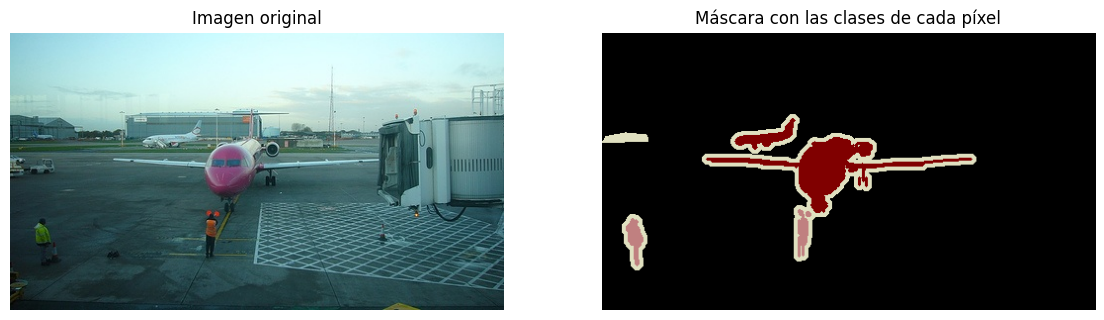

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(14,7))
ax[1].imshow(mask)
ax[0].imshow(img)
ax[0].set_title("Imagen original")
ax[1].set_title("Máscara con las clases de cada píxel")
ax[0].axis(False);
ax[1].axis(False);

In [12]:
np.unique(np.array(mask))

array([  0,   1,  15, 255], dtype=uint8)

Según la documentación del dataset:

"pixel indices correspond to classes in alphabetical order (1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle, 6=bus, 7=car , 8=cat, 9=chair, 10=cow, 11=diningtable, 12=dog, 13=horse, 14=motorbike, 15=person, 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor)"

"index 0 corresponds to background and index 255 corresponds to 'void' or unlabelled." -> caso de los bordes

Crearemos una clase para el dataset en la que se realicen las transformaciones y preprocesamientos necesarios.

In [13]:
class VOCSemSeg(torch.utils.data.Dataset):
    def __init__(self, images_list, img_dir, mask_dir, n_classes, transforms=None, use_borders=False):
        """
        Inicializa los atributos de la clase

        Params:
        - images_list: archivo de texto con los nombres de las imágenes
        - img_dir: directorio con las imágenes
        - mask_dir: directorio con las máscaras
        - transforms: Transformaciones a aplicar a las imágenes y máscaras. Útil para data augmentation
        - use_borders: Si queremos considerar el borde como una categoría más, o como background
        """
        super().__init__()
        self.img_dir = img_dir # Directorio con las imágenes
        self.mask_dir = mask_dir # Directorio con las máscaras
        self.transforms = transforms # Transformaciones a aplicar a las imángenes y máscaras
        self.use_borders = use_borders # Si queremos considerar el borde como una categoría más, o como background
        
        if use_borders:
            self.n_classes = n_classes + 2 # background y border
        else:
            self.n_classes = n_classes + 1 # bockground

        with open(images_list, 'r') as fp: # 
            self.images_list = [line.strip('\n') for line in fp.readlines()]

    def __len__(self):
        """Retorna el tamaño del dataset: cuántas imágenes hay en la lista"""
        return len(self.images_list)

    def __getitem__(self, idx):
        """Lee la imágen y máscara asociada a idx y aplica las transformaciones"""
        x = np.array(Image.open(os.path.join(self.img_dir, self.images_list[idx] + '.jpg')))
        mask = np.array(Image.open(os.path.join(self.mask_dir, self.images_list[idx] + '.png')))

        if self.use_borders:
            mask[mask == 255] = self.n_classes - 1 # Creo una clase más para el tipo "borde"
        else:
            mask[mask == 255] = 0 # Convierto el bodrde a background

        if self.transforms:
            augmented = self.transforms(image=x, mask=mask)
            x = augmented['image'].to(torch.float32)
            mask = augmented['mask']
        else:
            x = torch.Tensor(x)
            mask = torch.Tensor(mask)

        
        return x, mask.to(torch.long)

Hacemos una prueba de la clase

In [14]:
dataset = VOCSemSeg(images_list='VOC2012/ImageSets/Segmentation/train-sample.txt', img_dir='VOC2012/JPEGImages/', mask_dir='VOC2012/SegmentationClass/', n_classes=20)

In [15]:
x, y = dataset.__getitem__(10)

`x` deberá tener el tamaño y cantidad de canales de la imágen

In [16]:
x.shape

torch.Size([333, 500, 3])

El target tendrá las mismas dimensiones que la imágen, pero con una dimensión menos ya que cada píxel es representado por un valor entero (número de clase)

In [17]:
y.shape

torch.Size([333, 500])

## Entrenamiento y evaluación

Implementemos el loop de entrenamiento y las funciones que utilizaremos para evaluarlo

In [18]:
import torch.functional as F

### IoU

Una forma de calcular la performance del modelo es con la IoU por clase:

In [19]:
from collections import Counter

In [20]:
def iou(ground_truth, preds, per_class=False):
    """Calculamos la intersección sobre la unión"""
    # Obtenemos la etiqueta de cada pixel
    preds = preds.argmax(dim=1) 
    # Obtenemos las clases presentes
    # classes = set(torch.unique(ground_truth).tolist())
    classes = Counter()
    for i in range(ground_truth.shape[0]):
        classes_in_image = torch.unique(ground_truth[i])
        classes.update(classes_in_image.tolist())
    ious = {}
    # Calculamos la IoU por clase
    for c in classes:
        # Intersección
        preds_c = preds == c
        gt_c = ground_truth == c
        intersection = (preds_c & gt_c).sum(dim=(1, 2))
        # Union
        union = preds_c.sum(dim=(1, 2)) + gt_c.sum(dim=(1, 2)) - intersection        
        
        iou = intersection / union
        # Promedio entre las imágenes que contienen esa clase
        iou = iou.nansum() / classes[c]
        ious[c] = iou.item()
    
    # Agregamos la media
    ious['mean'] = sum(ious.values())/len(ious)

    if per_class:
        return ious
    else:
        return ious['mean']

### Accuracy
Como en todo problema de clasificación, se puede calcular el accuracy como métrica de desemepeño. Esto no es ideal para datasets desbalanceados. ¿Es útil para evaluar modelos de segmentación semántica?

In [21]:
def acc(ground_truth, preds):
    """Calculamos el accuracy a nivel píxel"""
    # Obtenemos la etiqueta de cada pixel
    preds = preds.argmax(dim=1) 
    ok = (preds == ground_truth).sum().item()
    total = np.prod(preds.shape)
    return ok/total

In [22]:
from tqdm import tqdm

### Loop de entrenamiento

Crearemos una función entrenar el modelo con un dataloader, la cual llamaremos EPOCH veces

In [23]:
def train_fn(loader, model, optimizer, loss_fn, epoch_n=None, eval_metrics=[]):
    """Función que entrena el modelo con todas las imágenes del loader, utilizando el optimizer y calculando la loss_fn"""
    # Inicializamos la loss de esta epoch en 0
    epoch_loss = 0
    # Instanciamos la barra de progreso
    loop = tqdm(loader, ncols=50, dynamic_ncols=True)
    if epoch_n is not None:
        loop.set_description_str(f"Epoch {epoch_n}")

    # Iteramos por las imágenes del batch
    for batch, (X, y) in enumerate(loop):

        # Reseteamos los gradientes
        optimizer.zero_grad()
        # Llevamos los datos al DEVICE
        X = X.to(DEVICE)
        y = y.to(DEVICE)

        # Procesamos las imágenes
        y_hat = model(X)

        # Calculamos la loss del batch e incrementamos la loss total
        loss = loss_fn(y_hat, y)
        epoch_loss += loss.item()

        # Calculamos los gradientes y actualizamos los parámetros del modelo
        loss.backward()
        optimizer.step()

        # Calculamos las métricas de evaluación:
        metrics = {'loss': loss.item()}
        for metric in eval_metrics:
            metrics[metric.__name__] = metric(y, y_hat)
        
        loop.set_postfix(**metrics)
        

    # Devolvemos la loss promedio de la epoch
    return epoch_loss/(batch+1)

Instanciamos el dataset, dataloader, modelo, la función de costo y el optimizador definiendo los hiperparámetros

In [24]:
EPOCHS = 500
BATCH_SIZE = 16
IMAGE_SIZE = 240 # Las imágenes no necesariamente tienen que ser cuadradas
N_CLASSES = 20
BORDERS = False

In [25]:
from albumentations.pytorch import ToTensorV2
import albumentations as A

Definimos las transformaciones que le aplicaremos a las imágenes antes de usarlas en el modelo. 

Acá se podrían agregar las transformaciones de data augmentation: 
- https://albumentations.ai/docs/getting_started/mask_augmentation/
- https://albumentations.ai/docs/examples/example_kaggle_salt/

In [26]:
transforms = A.Compose(
    [
        A.Resize(height=240,width=240),
        A.Normalize(
            mean=(0,0,0),
            std=(1,1,1),
            always_apply=True
        ),
        ToTensorV2()
    ]
)

In [27]:
train_dataset = VOCSemSeg(
    images_list='VOC2012/ImageSets/Segmentation/train-sample.txt',
    img_dir='VOC2012/JPEGImages/',
    mask_dir='VOC2012/SegmentationClass/',
    n_classes=N_CLASSES,
    transforms=transforms,
    use_borders=BORDERS
)

In [28]:
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

In [29]:
unet = UNet(
    in_channels=3, 
    n_classes=N_CLASSES,
    use_borders=BORDERS
).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(reduction='sum').to(DEVICE)

In [30]:
optimizer = torch.optim.Adam(params=unet.parameters())

In [31]:
for epoch in range(100):
    train_fn(train_loader, unet, optimizer, loss_fn, epoch, eval_metrics=[acc, iou])

Epoch 0: 100%|█| 1/1 [00:01<00:00,  1.40s/it, acc=0.018, iou=0.0253, loss=2.92e+
Epoch 1: 100%|█| 1/1 [00:00<00:00,  1.48it/s, acc=0.185, iou=0.0746, loss=2.72e+
Epoch 2: 100%|█| 1/1 [00:00<00:00,  1.58it/s, acc=0.428, iou=0.0972, loss=2.53e+
Epoch 3: 100%|█| 1/1 [00:00<00:00,  1.56it/s, acc=0.466, iou=0.0858, loss=2.41e+
Epoch 4: 100%|█| 1/1 [00:00<00:00,  1.58it/s, acc=0.516, iou=0.0852, loss=2.29e+
Epoch 5: 100%|█| 1/1 [00:00<00:00,  1.55it/s, acc=0.544, iou=0.0787, loss=2.21e+
Epoch 6: 100%|█| 1/1 [00:00<00:00,  1.57it/s, acc=0.555, iou=0.0711, loss=2.16e+
Epoch 7: 100%|█| 1/1 [00:00<00:00,  1.55it/s, acc=0.566, iou=0.07, loss=2.11e+6]
Epoch 8: 100%|█| 1/1 [00:00<00:00,  1.58it/s, acc=0.569, iou=0.0721, loss=2.07e+
Epoch 9: 100%|█| 1/1 [00:00<00:00,  1.54it/s, acc=0.582, iou=0.0875, loss=2.04e+
Epoch 10: 100%|██| 1/1 [00:00<00:00,  1.58it/s, acc=0.591, iou=0.105, loss=2e+6]
Epoch 11: 100%|█| 1/1 [00:00<00:00,  1.58it/s, acc=0.595, iou=0.119, loss=1.97e+
Epoch 12: 100%|█| 1/1 [00:00

Notar cómo el accuracy crece mucho más rápido que el IoU, alcanzando valores cercanos a 1 mientras que el IoU apenas supera el 0.6

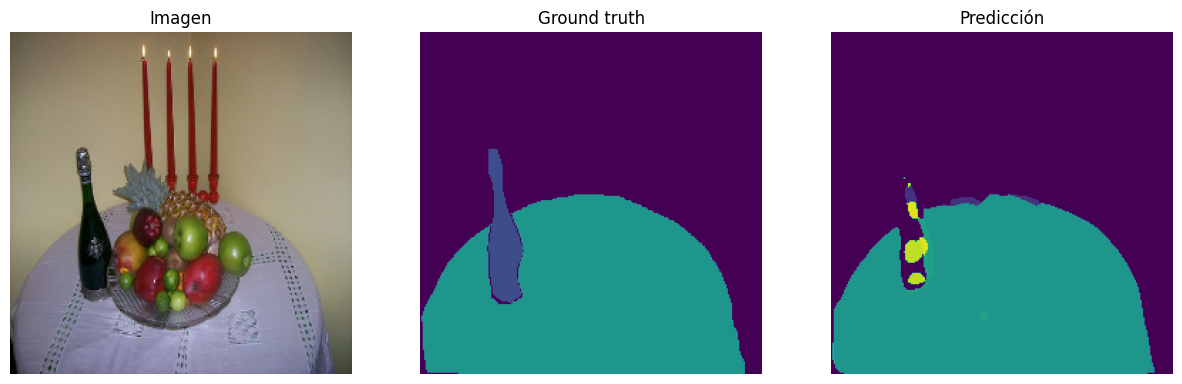

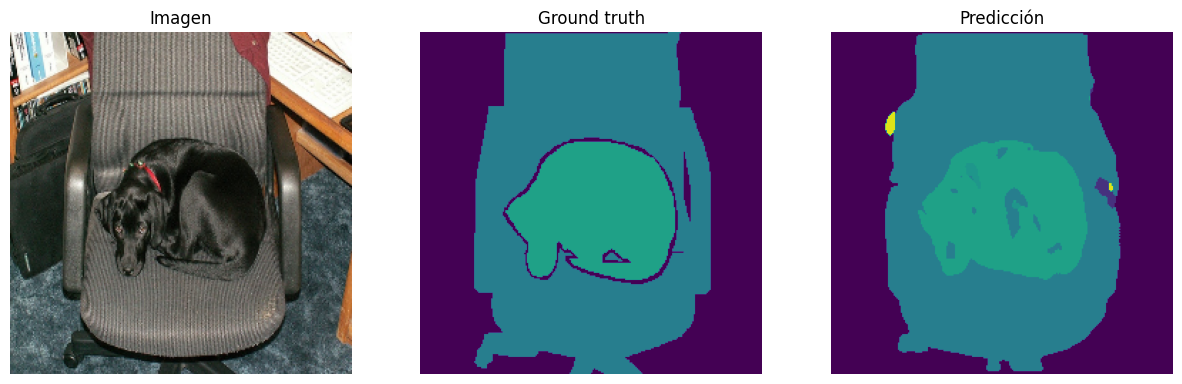

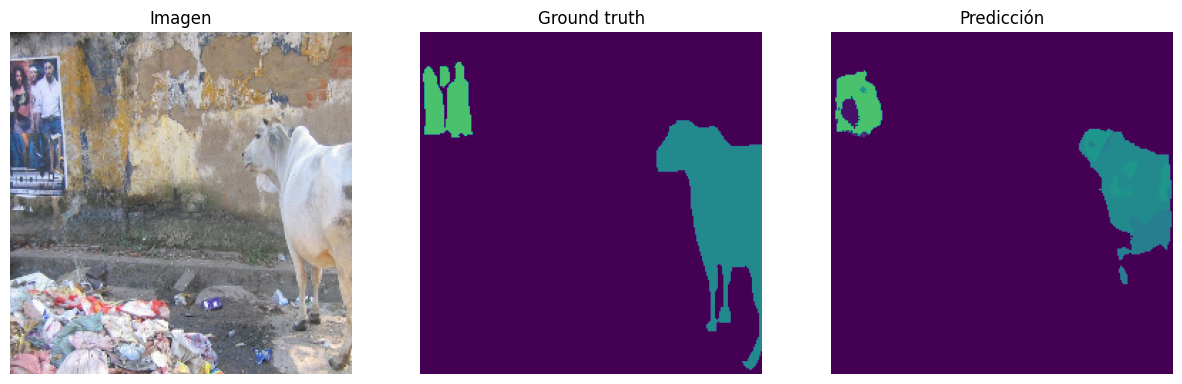

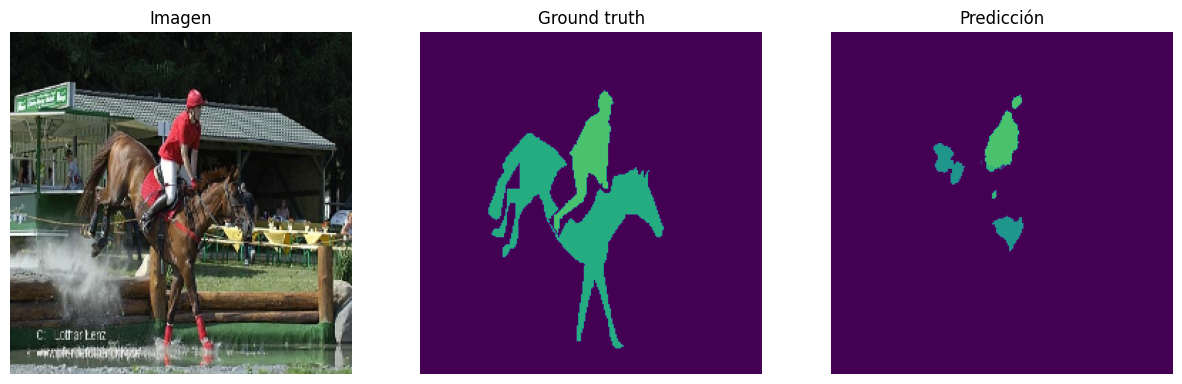

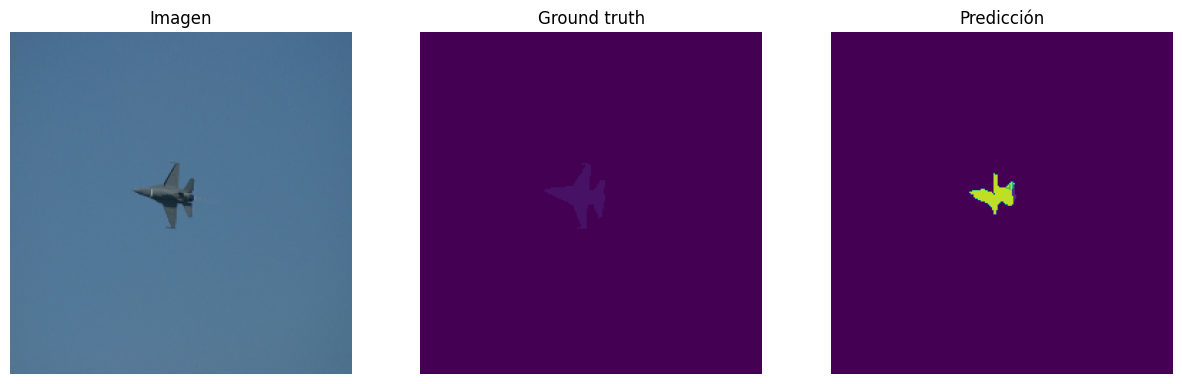

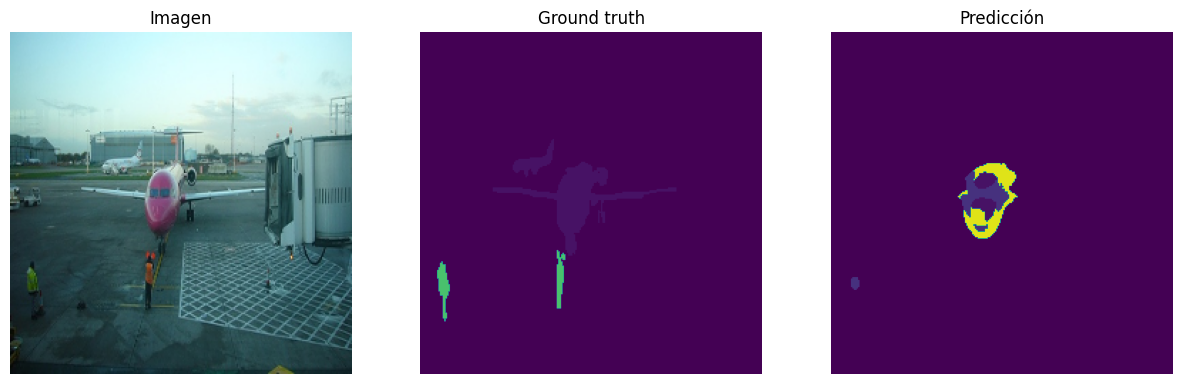

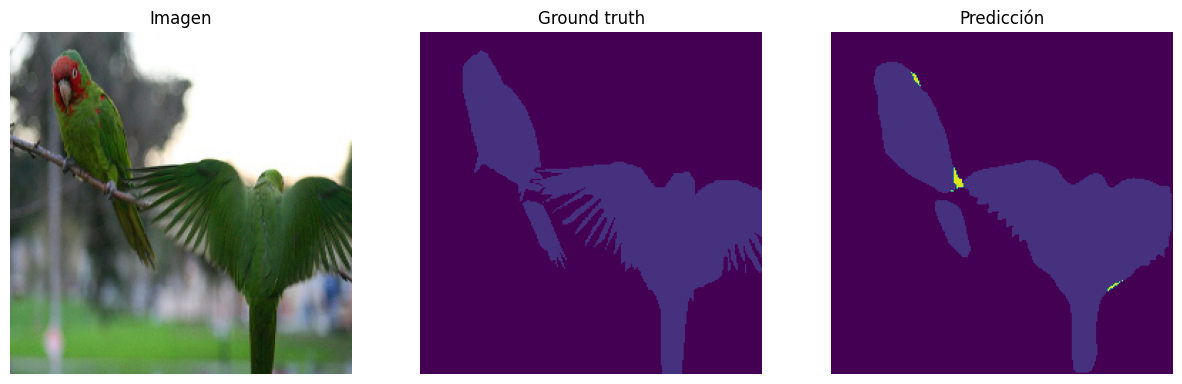

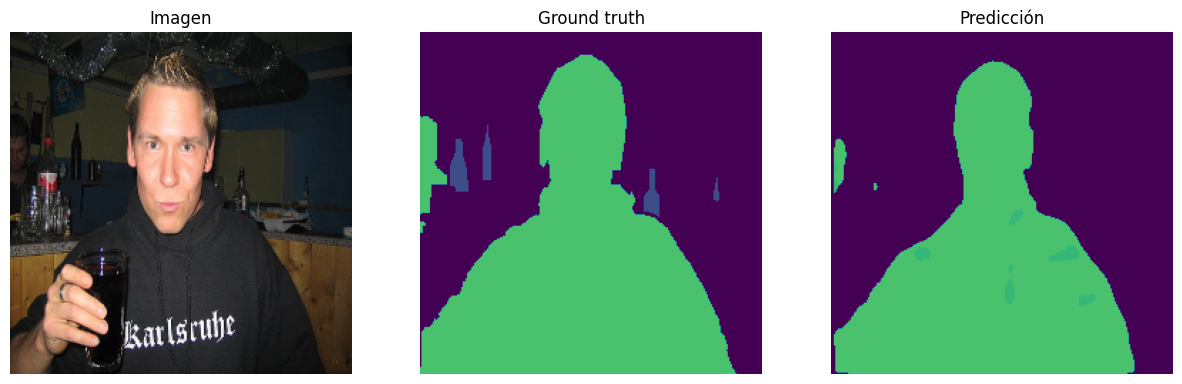

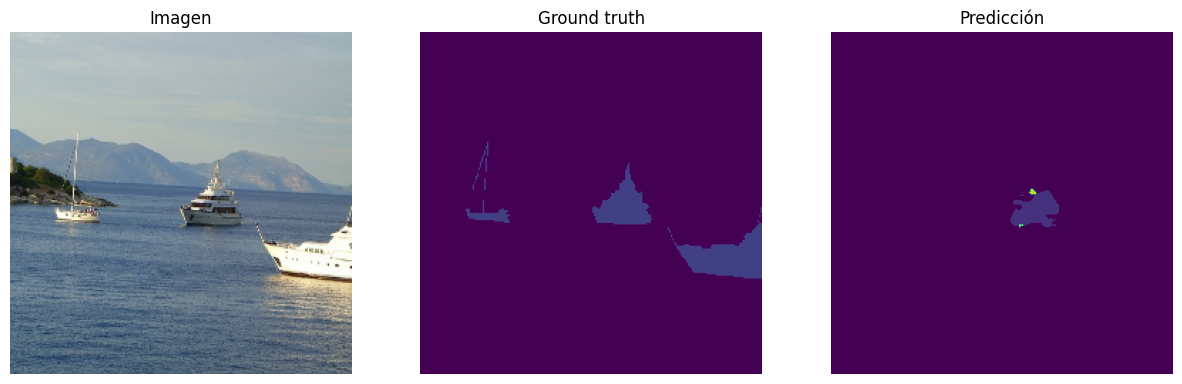

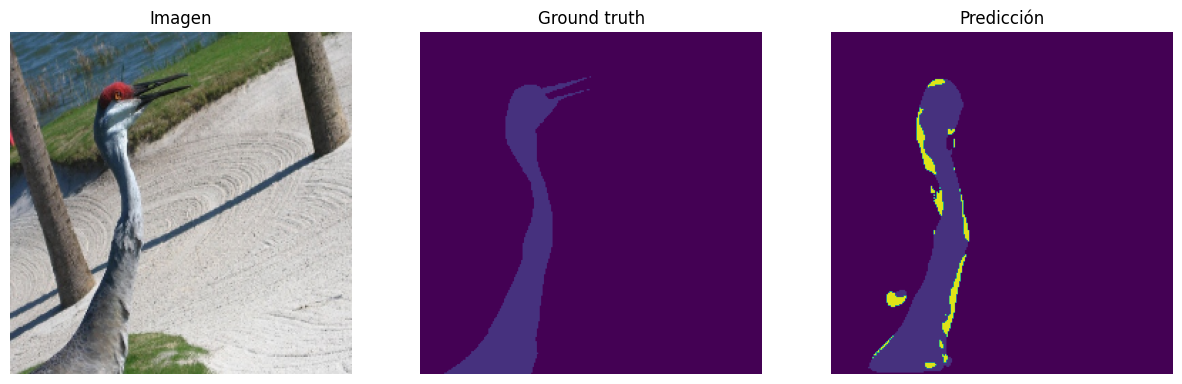

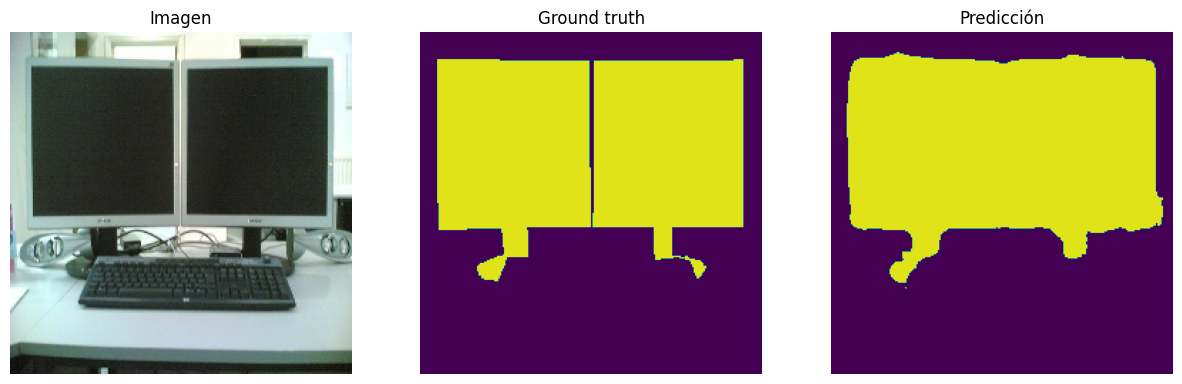

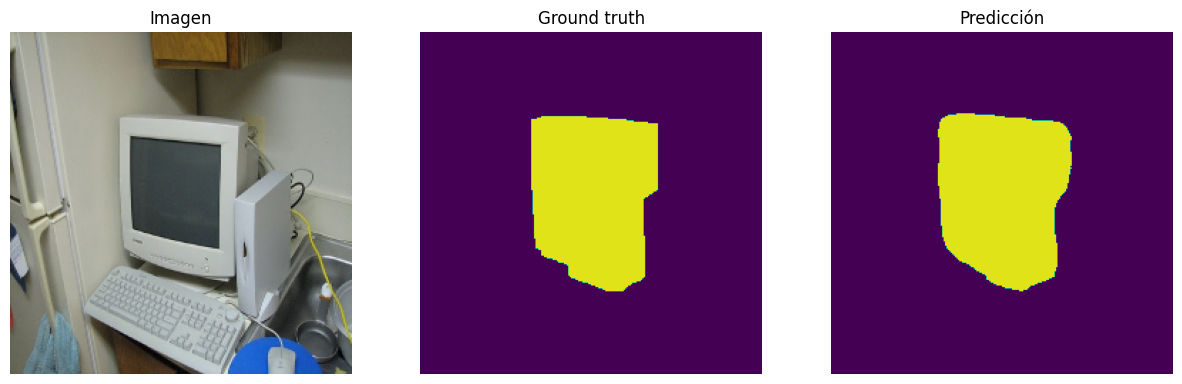

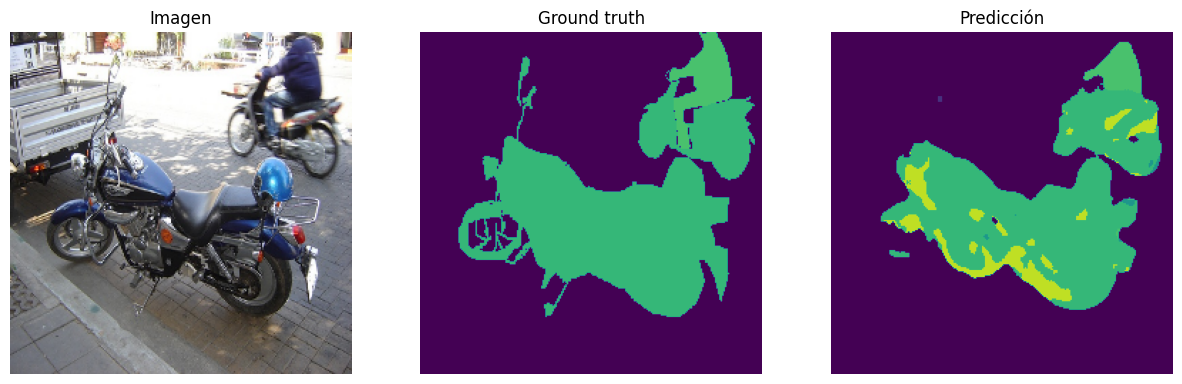

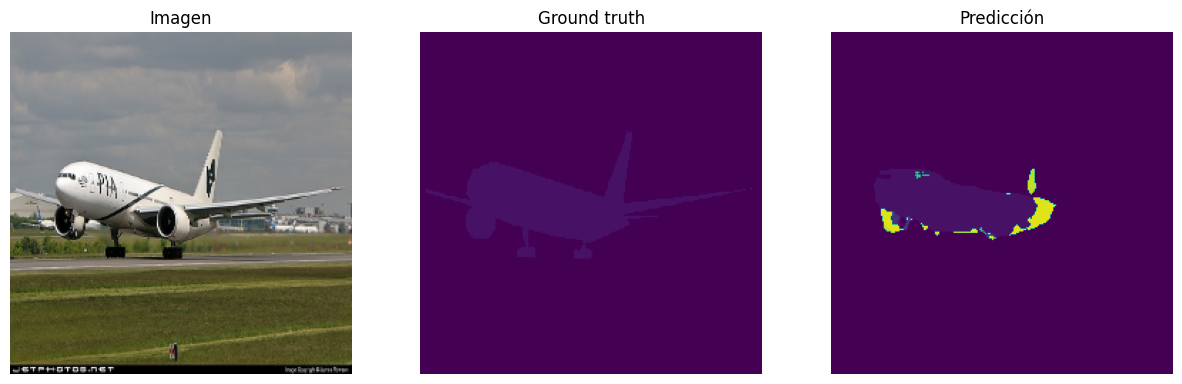

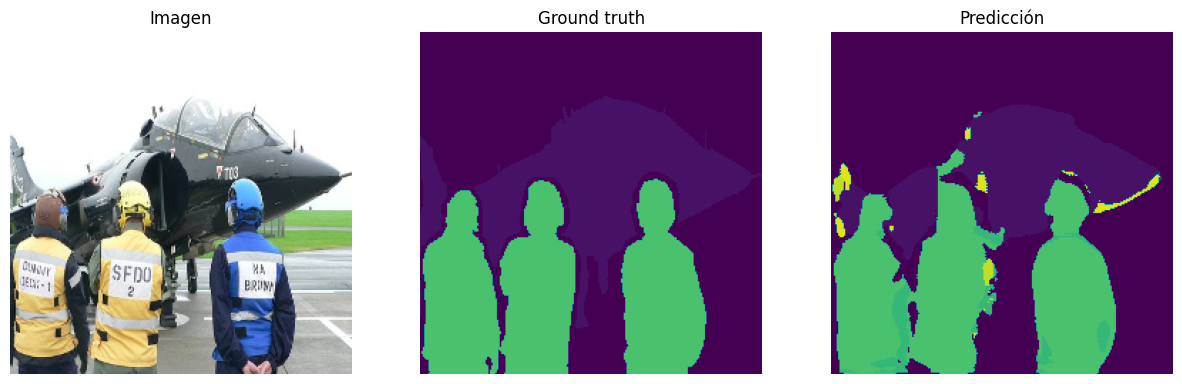

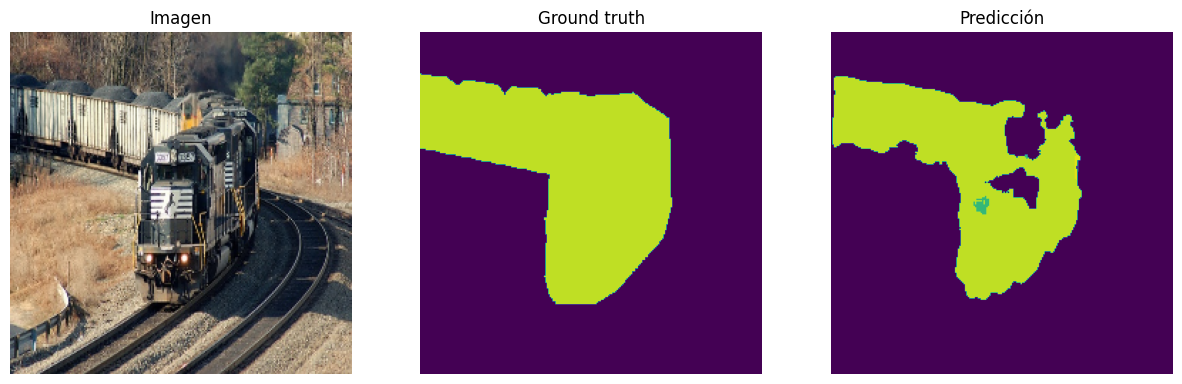

In [33]:
unet.eval()
for X, y in train_loader:
    X = X.to(DEVICE)
    
    with torch.no_grad():
        y_hat = unet(X)
        y_hat = y_hat.to('cpu')
        X = X.to('cpu').permute(0, 2, 3, 1)
    for i in range(y_hat.shape[0]):
        fix, ax = plt.subplots(ncols=3, figsize=(15, 6))
        ax[0].imshow(X[i])
        ax[1].imshow(y[i], vmin=0, vmax=21)
        ax[2].imshow(y_hat[i].argmax(dim=0), vmin=0, vmax=21)
        ax[0].set_title("Imagen")
        ax[1].set_title("Ground truth")
        ax[2].set_title("Predicción")
        ax[0].axis(False);
        ax[1].axis(False);
        ax[2].axis(False);
unet.train();

Continuemos con el entrenamiento otras 100 epochs...

In [34]:
for epoch in range(100):
    train_fn(train_loader, unet, optimizer, loss_fn, epoch, eval_metrics=[acc, iou])

Epoch 0: 100%|█| 1/1 [00:00<00:00,  1.59it/s, acc=0.964, iou=0.641, loss=2.2e+5]
Epoch 1: 100%|█| 1/1 [00:00<00:00,  1.60it/s, acc=0.964, iou=0.633, loss=2.14e+5
Epoch 2: 100%|█| 1/1 [00:00<00:00,  1.57it/s, acc=0.966, iou=0.649, loss=2.08e+5
Epoch 3: 100%|█| 1/1 [00:00<00:00,  1.60it/s, acc=0.967, iou=0.654, loss=2.04e+5
Epoch 4: 100%|█| 1/1 [00:00<00:00,  1.58it/s, acc=0.968, iou=0.658, loss=1.98e+5
Epoch 5: 100%|█| 1/1 [00:00<00:00,  1.59it/s, acc=0.968, iou=0.665, loss=1.94e+5
Epoch 6: 100%|█| 1/1 [00:00<00:00,  1.60it/s, acc=0.969, iou=0.667, loss=1.89e+5
Epoch 8: 100%|█| 1/1 [00:00<00:00,  1.58it/s, acc=0.97, iou=0.677, loss=1.81e+5]
Epoch 9: 100%|█| 1/1 [00:00<00:00,  1.59it/s, acc=0.971, iou=0.678, loss=1.77e+5
Epoch 10: 100%|█| 1/1 [00:00<00:00,  1.55it/s, acc=0.972, iou=0.683, loss=1.72e+
Epoch 11: 100%|█| 1/1 [00:00<00:00,  1.50it/s, acc=0.972, iou=0.687, loss=1.69e+
Epoch 12: 100%|█| 1/1 [00:00<00:00,  1.58it/s, acc=0.972, iou=0.684, loss=1.66e+
Epoch 13: 100%|█| 1/1 [00:00

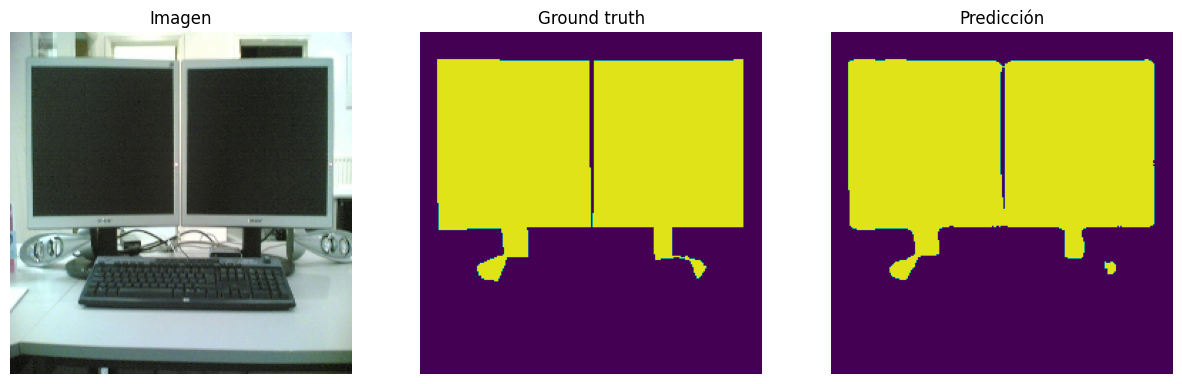

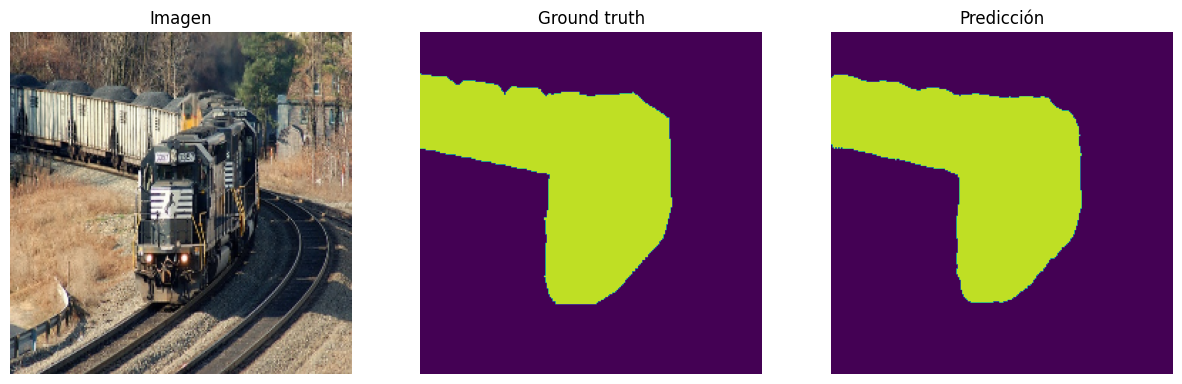

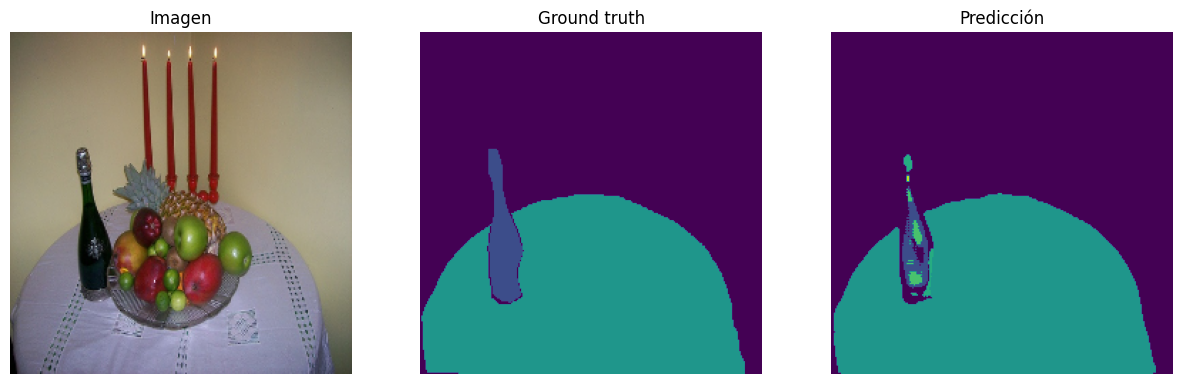

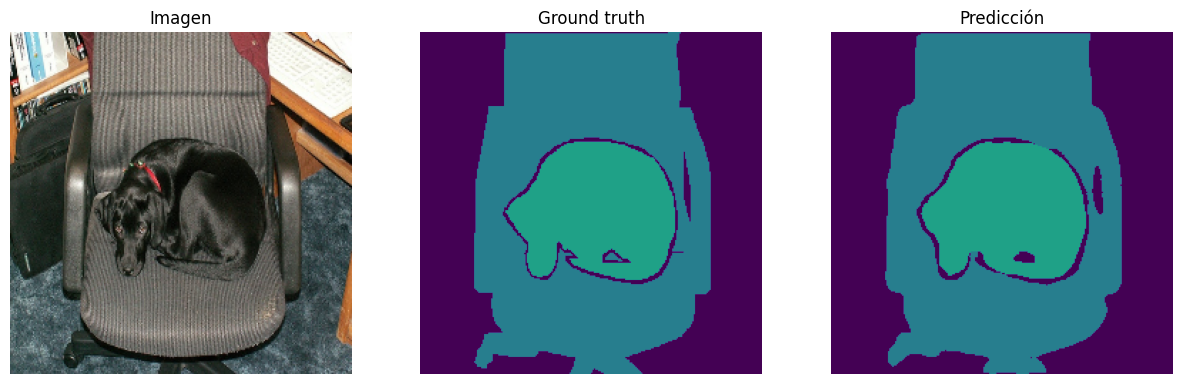

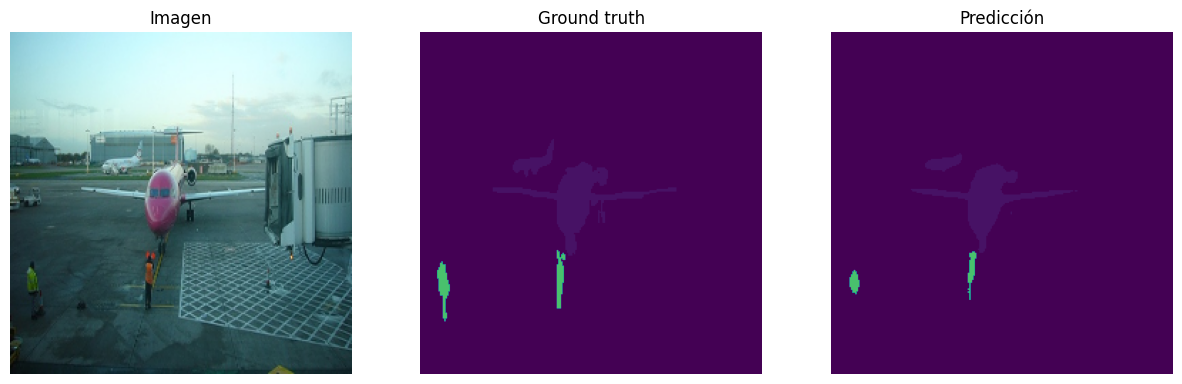

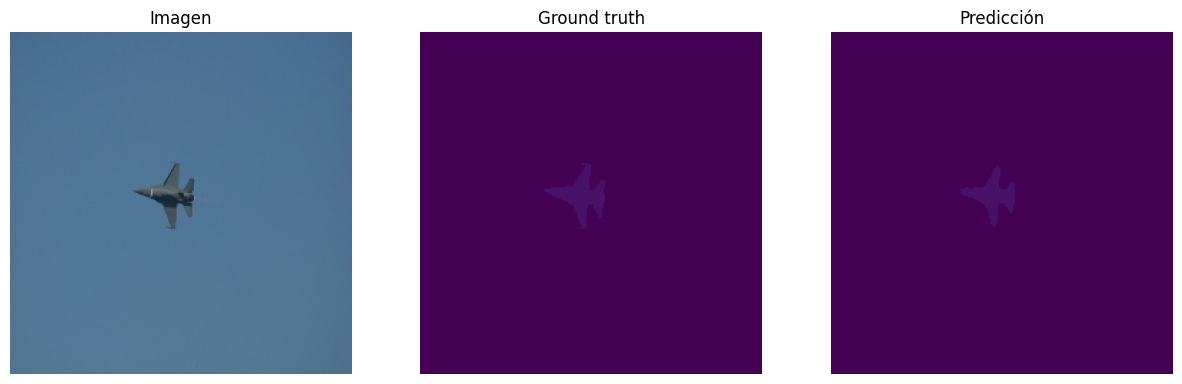

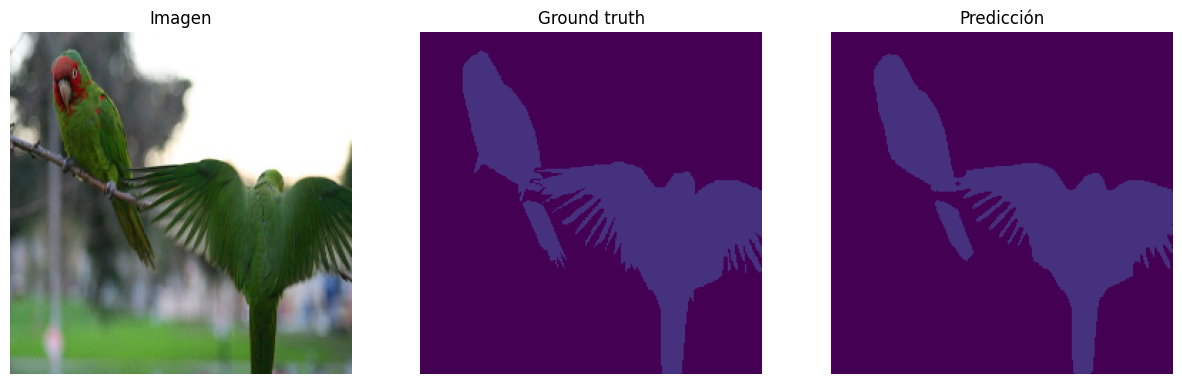

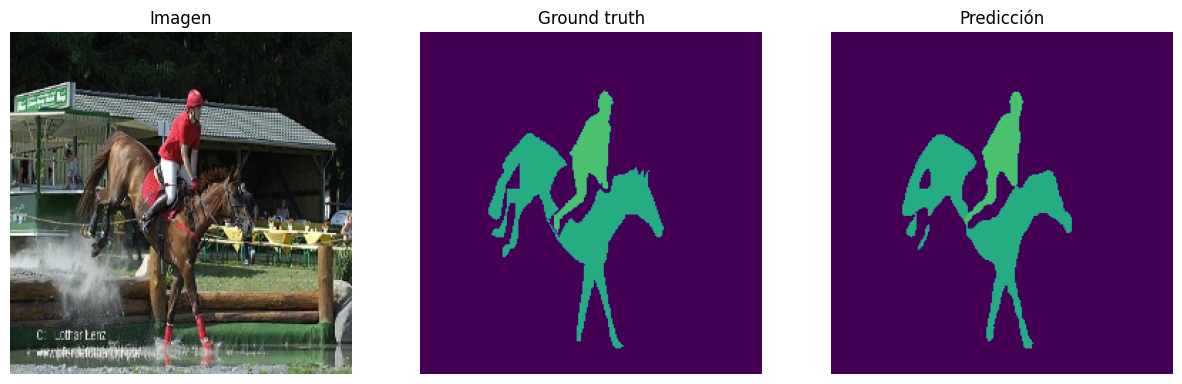

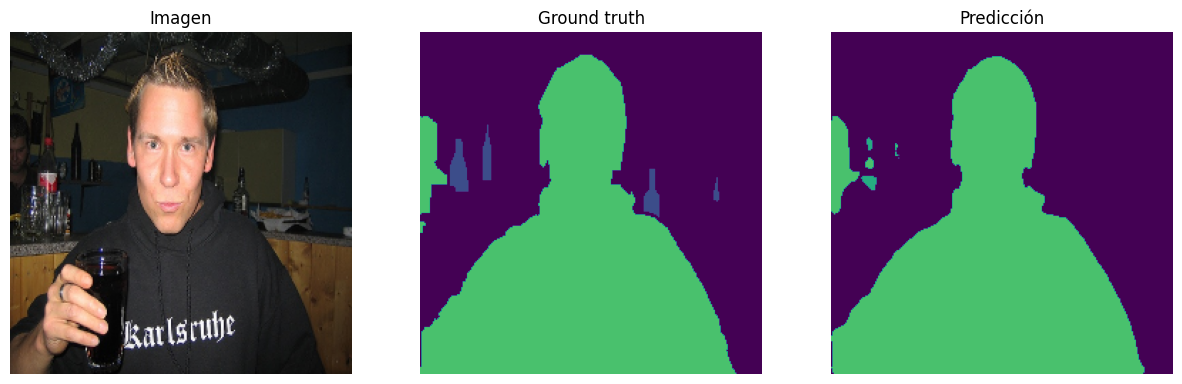

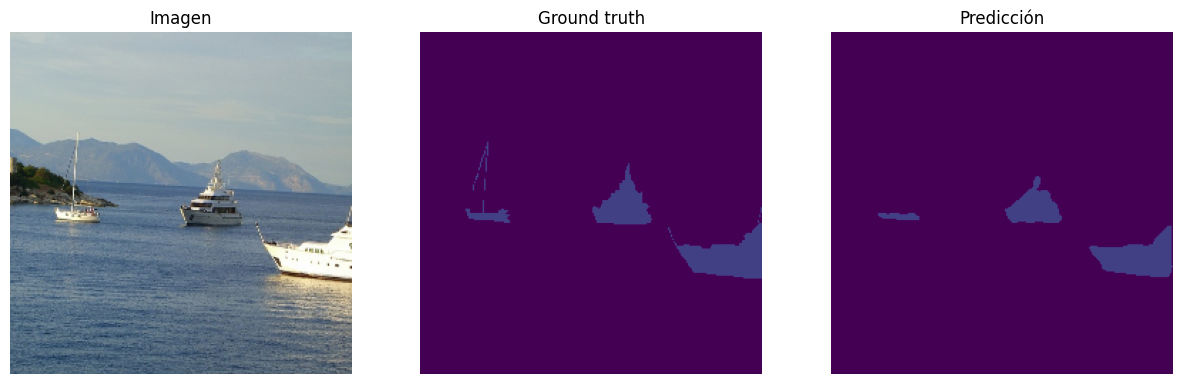

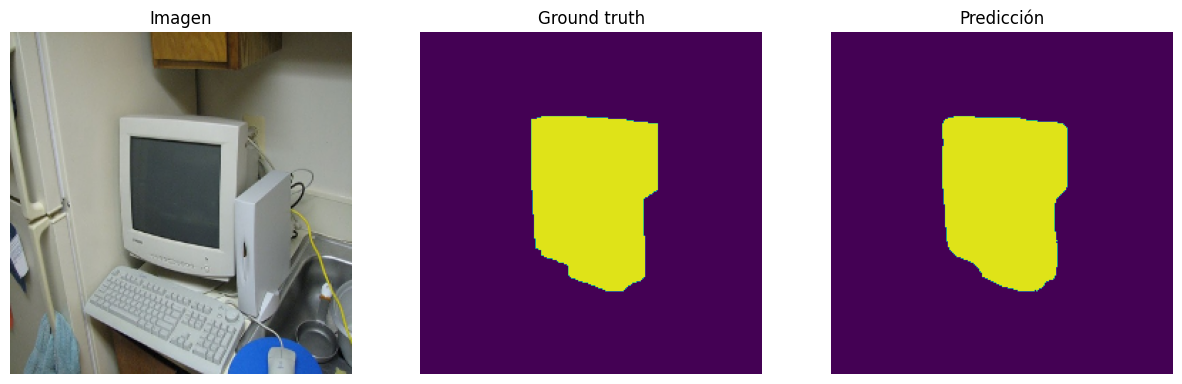

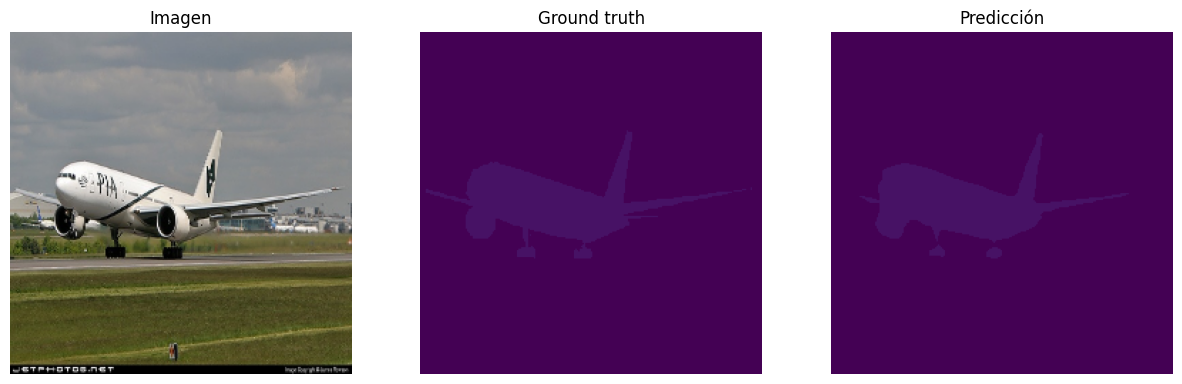

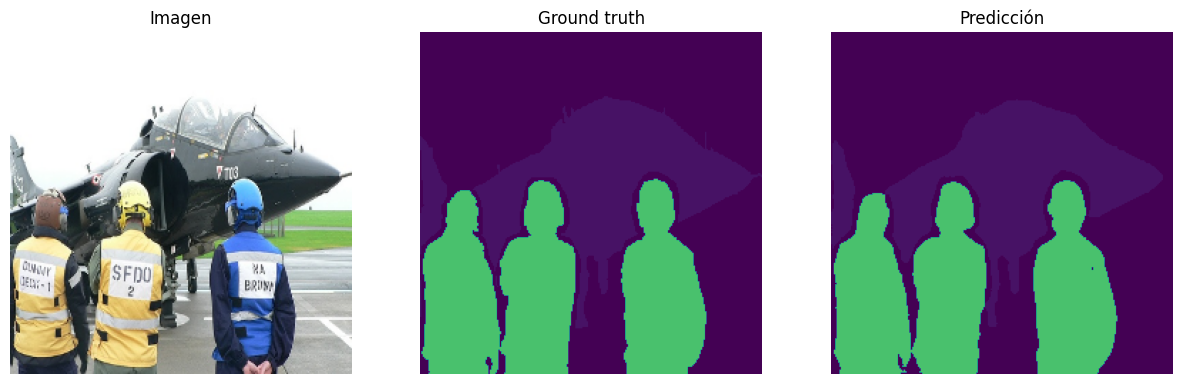

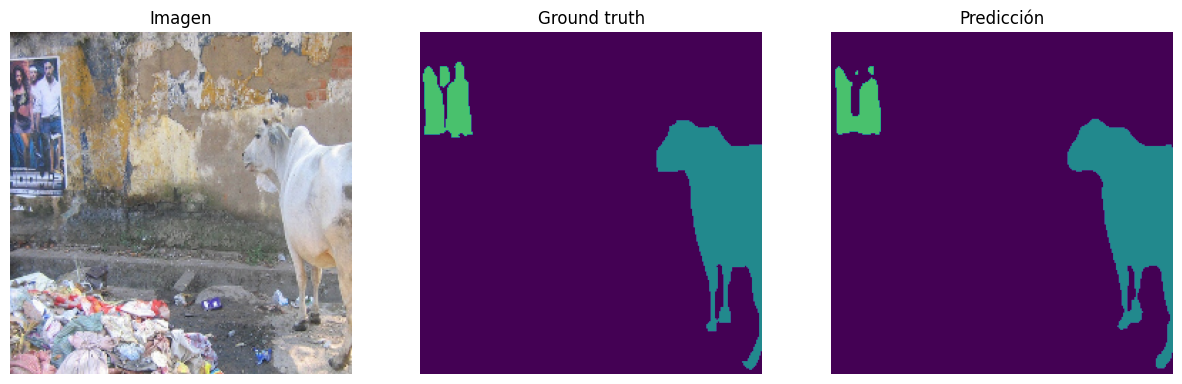

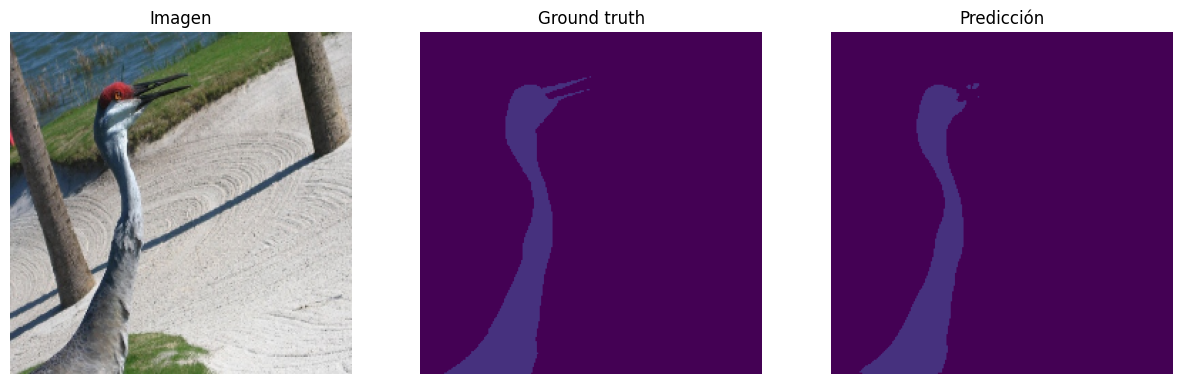

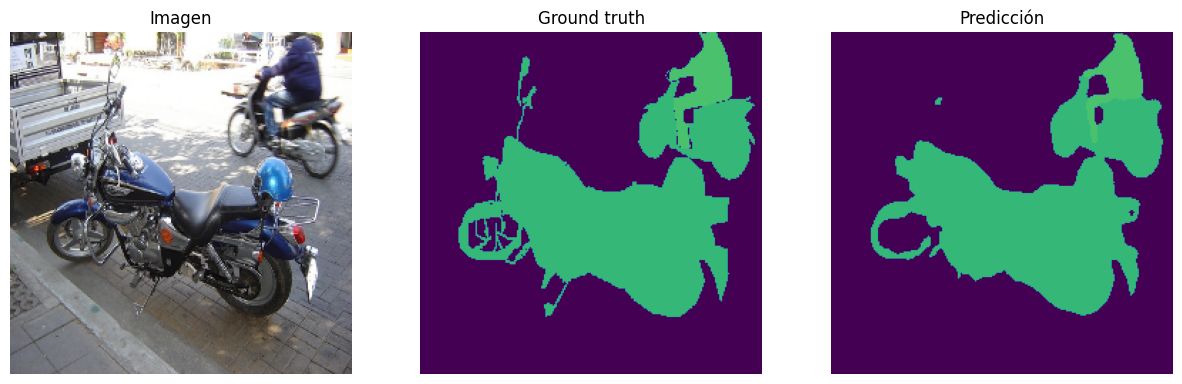

In [35]:
unet.eval()
for X, y in train_loader:
    X = X.to(DEVICE)
    
    with torch.no_grad():
        y_hat = unet(X)
        y_hat = y_hat.to('cpu')
        X = X.to('cpu').permute(0, 2, 3, 1)
    for i in range(y_hat.shape[0]):
        fix, ax = plt.subplots(ncols=3, figsize=(15, 6))
        ax[0].imshow(X[i])
        ax[1].imshow(y[i], vmin=0, vmax=21)
        ax[2].imshow(y_hat[i].argmax(dim=0), vmin=0, vmax=21)
        ax[0].set_title("Imagen")
        ax[1].set_title("Ground truth")
        ax[2].set_title("Predicción")
        ax[0].axis(False);
        ax[1].axis(False);
        ax[2].axis(False);
unet.train();